# Capstone2 Exploratory Data Analysis for Mental Health Dataset

## Table of Contents
1. [Import Libraries](#1.-Import-Libraries)
2. [Review the Mental Health Dataset](#2.-Review-the-Mental-Health-Dataset)
3. [Data Cleaning](#3.-Data-Cleaning)
4. [Exploratory Data Analysis](#4.-Exploratory-Data-Analysis)
5. [Feature Engineering](#5.-Feature-Engineering)
6. [Baseline Model and Testing](#6.-Baseline-Model-and-Testing)
7. [Summary](#7.-Summary)


## 1. Import Libraries

In [1]:
# Import libraries for dataset operations
import numpy as np
import pandas as pd

# Import stats libraries
from scipy.stats import chi2_contingency
from sklearn.metrics import confusion_matrix

# Import libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns


## 2. Review the Mental Health Dataset

In [2]:
 # Load data
df = pd.read_csv('./MentalHealthDataset.csv')
df.head()

,Timestamp,Gender,Country,Occupation,self_employed,family_history,treatment,Days_Indoors,Growing_Stress,Changes_Habits,Mental_Health_History,Mood_Swings,Coping_Struggles,Work_Interest,Social_Weakness,mental_health_interview,care_options
0,8/27/2014 11:29,Female,United States,Corporate,NaN,No,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Not sure
1,8/27/2014 11:31,Female,United States,Corporate,NaN,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,No
2,8/27/2014 11:32,Female,United States,Corporate,NaN,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Yes
3,8/27/2014 11:37,Female,United States,Corporate,No,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,Maybe,Yes
4,8/27/2014 11:43,Female,United States,Corporate,No,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Yes


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292364 entries, 0 to 292363
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   Timestamp                292364 non-null  object
 1   Gender                   292364 non-null  object
 2   Country                  292364 non-null  object
 3   Occupation               292364 non-null  object
 4   self_employed            287162 non-null  object
 5   family_history           292364 non-null  object
 6   treatment                292364 non-null  object
 7   Days_Indoors             292364 non-null  object
 8   Growing_Stress           292364 non-null  object
 9   Changes_Habits           292364 non-null  object
 10  Mental_Health_History    292364 non-null  object
 11  Mood_Swings              292364 non-null  object
 12  Coping_Struggles         292364 non-null  object
 13  Work_Interest            292364 non-null  object
 14  Social_Weakness     

In [4]:
df.isnull().sum()

Timestamp                     0
Gender                        0
Country                       0
Occupation                    0
self_employed              5202
family_history                0
treatment                     0
Days_Indoors                  0
Growing_Stress                0
Changes_Habits                0
Mental_Health_History         0
Mood_Swings                   0
Coping_Struggles              0
Work_Interest                 0
Social_Weakness               0
mental_health_interview       0
care_options                  0
dtype: int64

In [5]:
df.duplicated().sum()

2313

There are **2313** duplicate records.
**5202** rows have missing values in the feature 'self_employed'.

#### Analyzing Duplicates

In [6]:
df.Timestamp.value_counts()

Timestamp
8/27/2014 11:43    2384
8/27/2014 12:31    2340
8/27/2014 12:53    1648
8/27/2014 16:21    1604
8/27/2014 12:39    1604
                   ... 
8/27/2014 23:54     390
8/27/2014 23:30     390
8/27/2014 23:14     390
8/27/2014 23:10     390
2/1/2016 23:04      390
Name: count, Length: 580, dtype: int64

Out of 292K records, there are only 580 unique time entries.
It is possible that these records were entered using batch method, that is why there are multiple rows having the same time entry.

Let us check how these duplications are spread across the time entry groups. 

In [7]:
aggregated_df = df.groupby(['Timestamp'])
groups = aggregated_df.groups
#groups
total_dups = 0
group_dups = 0 
for name in groups:
    group = aggregated_df.get_group((name,))
    dups = group.duplicated().sum()
    if dups != 0:
        #print(f'Group: {name}, Countries: {group.Country.unique()}, duplicates: {dups}')
        total_dups += dups
        group_dups += 1
print(f'Total Duplicates: {total_dups}, Groups with Duplicates: {group_dups} out of {len(groups)}')


Total Duplicates: 2313, Groups with Duplicates: 122 out of 580


The duplicates are spread across multiple timestamps, and Country. Each group on average have 3 duplicates. Some groups also have more duplicates than average:

```
Group: 2014-08-27 12:39:00, Countries: ['United States'], duplicates: 393
Group: 2014-08-27 12:40:00, Countries: ['United States' 'Canada'], duplicates: 3
Group: 2014-08-27 12:42:00, Countries: ['United States'], duplicates: 390
Group: 2014-08-27 12:49:00, Countries: ['United States' 'Canada'], duplicates: 6
Group: 2014-08-27 12:50:00, Countries: ['United States' 'United Kingdom'], duplicates: 3
Group: 2014-08-27 12:51:00, Countries: ['United Kingdom' 'United States'], duplicates: 3
```

It is possible that the batching process have introduced duplication. To reduce complication in our models, we drop the duplicates.

## 3. Data Cleaning


### Drop Duplicates

In [8]:
print(f'Num. duplicates: {df.duplicated().sum()}')
print(f'% duplicates: {df.duplicated().mean():.3f}')

Num. duplicates: 2313
% duplicates: 0.008


There is less than 1% duplicates. Dropping the duplicates should have no effect to our analysis. 

In [9]:
df.drop_duplicates(inplace=True)
print(f'Num. duplicates: {df.duplicated().sum()}')

Num. duplicates: 0


### Drop Timestamp

We are dropping timestamp as we are not interested in the captured time of the record.

In [10]:
df.drop(labels='Timestamp', axis=1, inplace=True)

### Missing Data

Fill in missing 'self-employed' values by calculating and using the mode.

In [11]:
df['self_employed'].fillna(df['self_employed'].mode()[0], inplace=True)
df.isnull().sum()

/var/folders/4p/9y8h6r_j2vv49_80h13f2lhw0000gn/T/ipykernel_47153/452681641.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['self_employed'].fillna(df['self_employed'].mode()[0], inplace=True)


Gender                     0
Country                    0
Occupation                 0
self_employed              0
family_history             0
treatment                  0
Days_Indoors               0
Growing_Stress             0
Changes_Habits             0
Mental_Health_History      0
Mood_Swings                0
Coping_Struggles           0
Work_Interest              0
Social_Weakness            0
mental_health_interview    0
care_options               0
dtype: int64

## 4. Exploratory Data Analysis

### Bivariate Analysis
#### Show the proportions of the target categories ('treatment') for each feature category.


In [12]:
def explore_feature_vs_target(data, feature, target):
    """
        Explore how a categorical feature relates to the target 
        using cross-tab and grouped bar chart.
    """
    # Cross-tabulation
    cross_tab = pd.crosstab(data[feature], data[target], normalize='index')
    print(f'{target} by {feature}:')
    print(cross_tab)
    
    # Plotting the grouped bar chart
    plt.figure(figsize=(8, 5))
    ax = sns.countplot(x=feature, hue=target, data=data, palette='Set2')
    if feature != 'Country':
        for i in ax.containers:
            ax.bar_label(i)
    plt.title(f'{target} by {feature}', fontsize=16)
    plt.xlabel(feature, fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.legend(title=target)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

treatment by Gender:
treatment        No       Yes
Gender                       
Female     0.305785  0.694215
Male       0.537705  0.462295


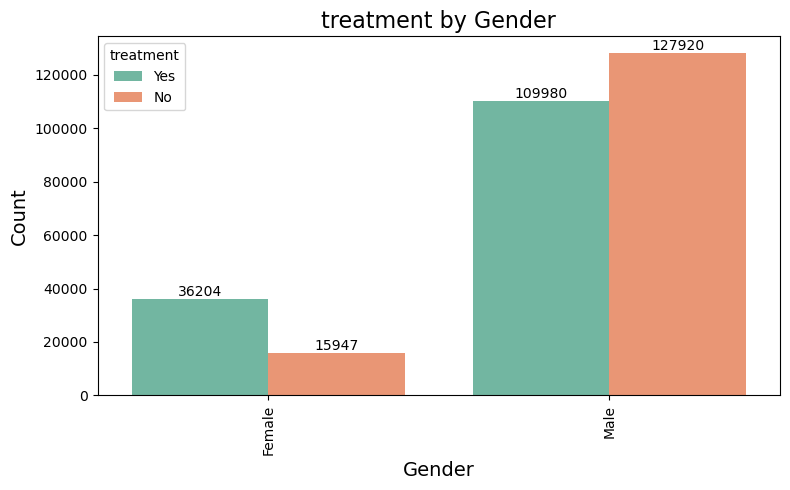

treatment by Country:
treatment                     No       Yes
Country                                   
Australia               0.395910  0.604090
Belgium                 1.000000  0.000000
Bosnia and Herzegovina  1.000000  0.000000
Brazil                  0.666667  0.333333
Canada                  0.461041  0.538959
Colombia                1.000000  0.000000
Costa Rica              1.000000  0.000000
Croatia                 0.000000  1.000000
Czech Republic          1.000000  0.000000
Denmark                 0.000000  1.000000
Finland                 1.000000  0.000000
France                  1.000000  0.000000
Georgia                 1.000000  0.000000
Germany                 0.500000  0.500000
Greece                  1.000000  0.000000
India                   0.703717  0.296283
Ireland                 0.507398  0.492602
Israel                  1.000000  0.000000
Italy                   1.000000  0.000000
Mexico                  1.000000  0.000000
Moldova                 0.000000

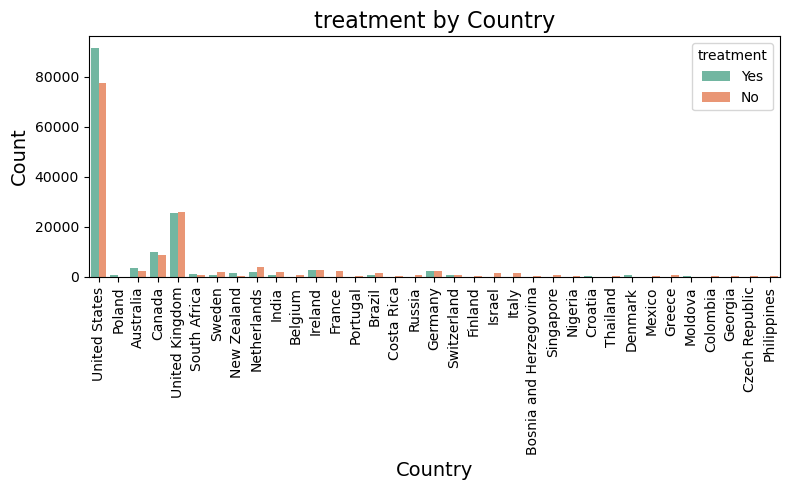

treatment by Occupation:
treatment         No       Yes
Occupation                    
Business    0.493205  0.506795
Corporate   0.503947  0.496053
Housewife   0.496829  0.503171
Others      0.492162  0.507838
Student     0.492818  0.507182


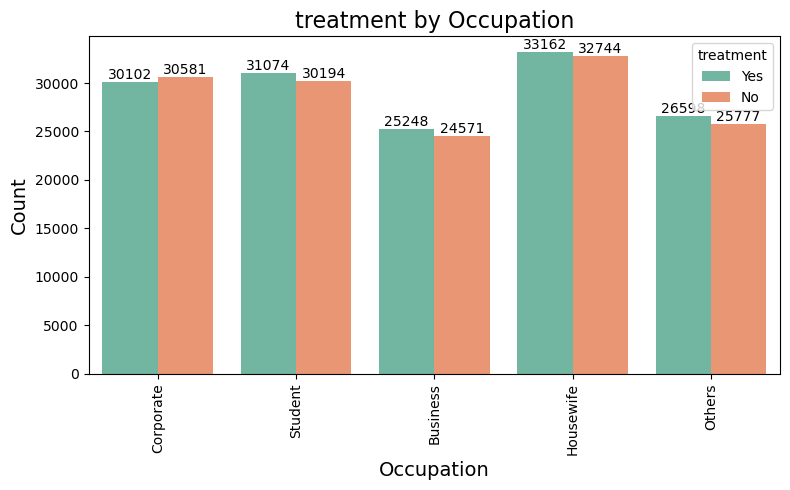

treatment by self_employed:
treatment            No       Yes
self_employed                    
No             0.502089  0.497911
Yes            0.441555  0.558445


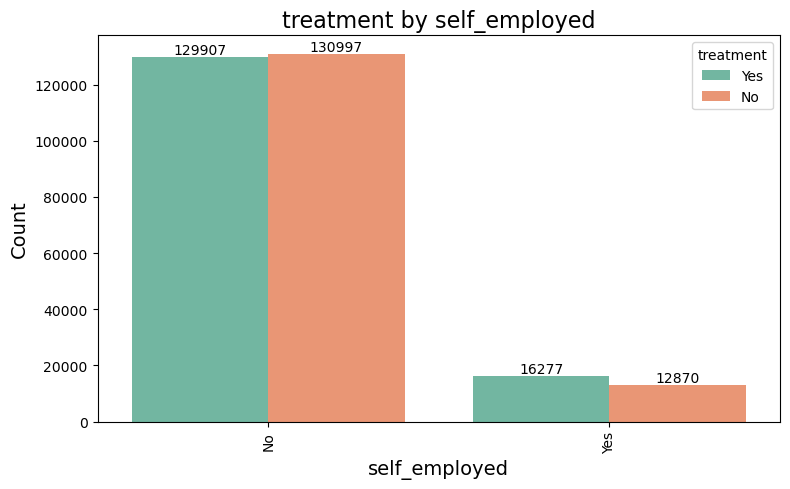

treatment by family_history:
treatment             No       Yes
family_history                    
No              0.643319  0.356681
Yes             0.270254  0.729746


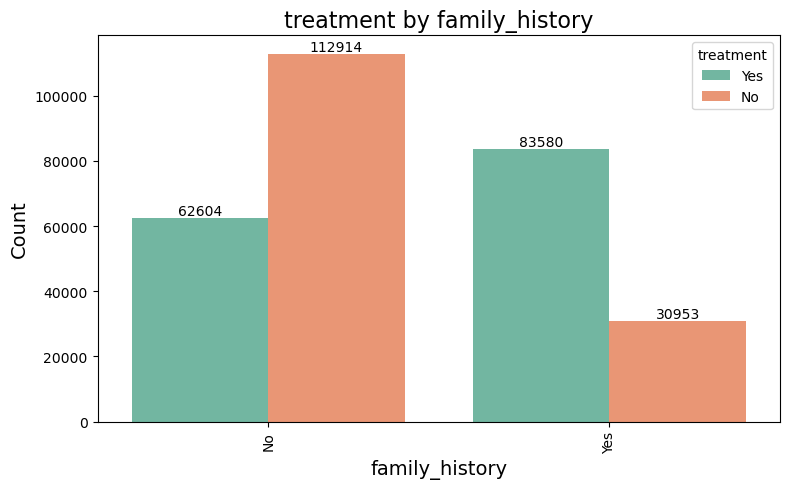

treatment by Days_Indoors:
treatment                 No       Yes
Days_Indoors                          
1-14 days           0.500800  0.499200
15-30 days          0.493623  0.506377
31-60 days          0.496587  0.503413
Go out Every day    0.493662  0.506338
More than 2 months  0.494668  0.505332


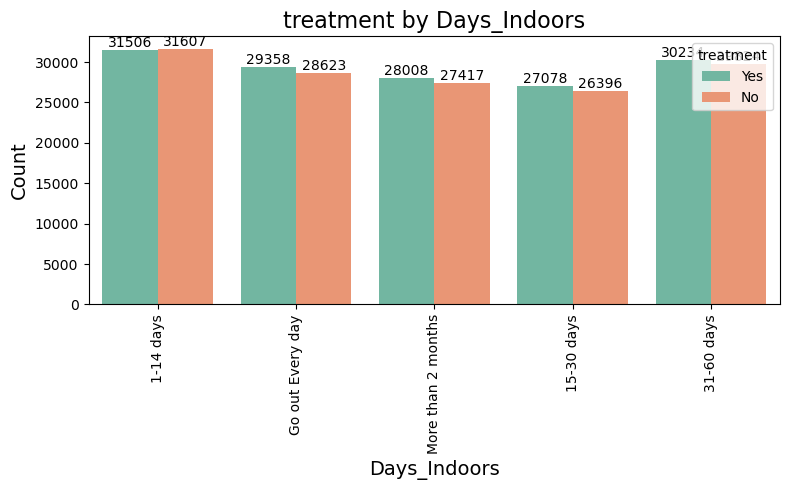

treatment by Growing_Stress:
treatment             No       Yes
Growing_Stress                    
Maybe           0.500967  0.499033
No              0.498043  0.501957
Yes             0.489121  0.510879


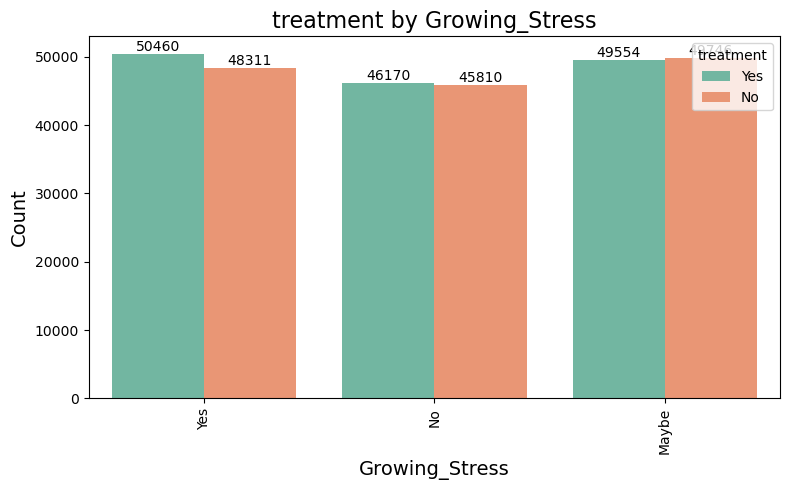

treatment by Changes_Habits:
treatment             No       Yes
Changes_Habits                    
Maybe           0.496336  0.503664
No              0.494470  0.505530
Yes             0.496948  0.503052


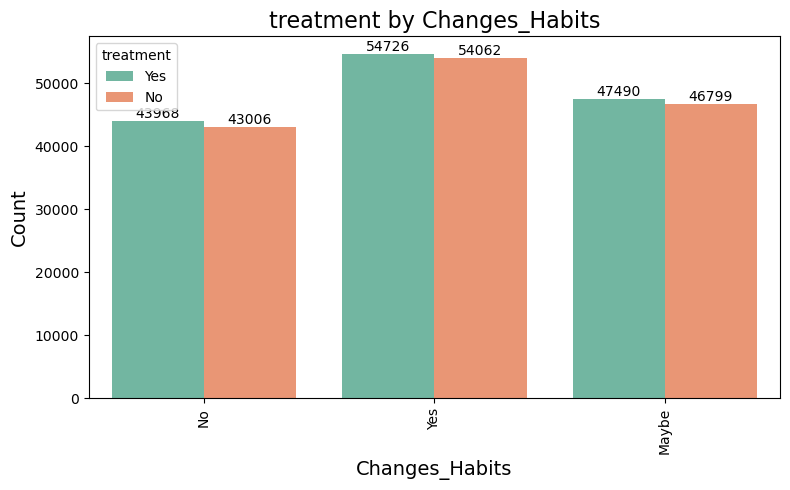

treatment by Mental_Health_History:
treatment                    No       Yes
Mental_Health_History                    
Maybe                  0.491388  0.508612
No                     0.498863  0.501137
Yes                    0.497539  0.502461


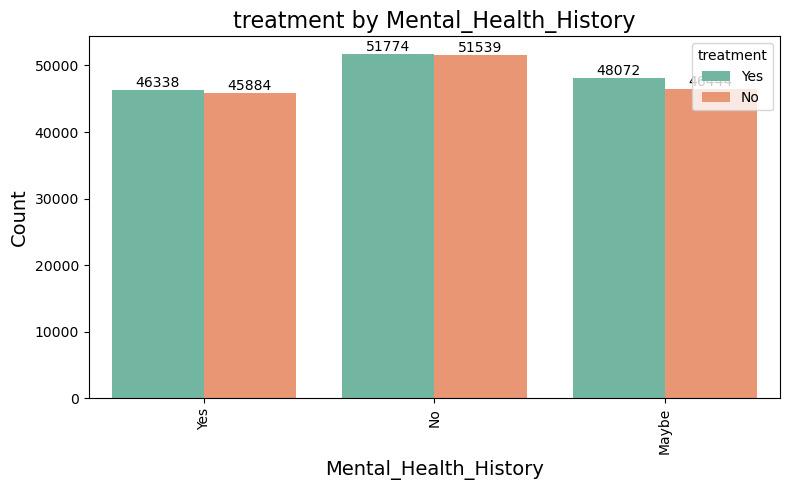

treatment by Mood_Swings:
treatment          No       Yes
Mood_Swings                    
High         0.493365  0.506635
Low          0.496955  0.503045
Medium       0.497450  0.502550


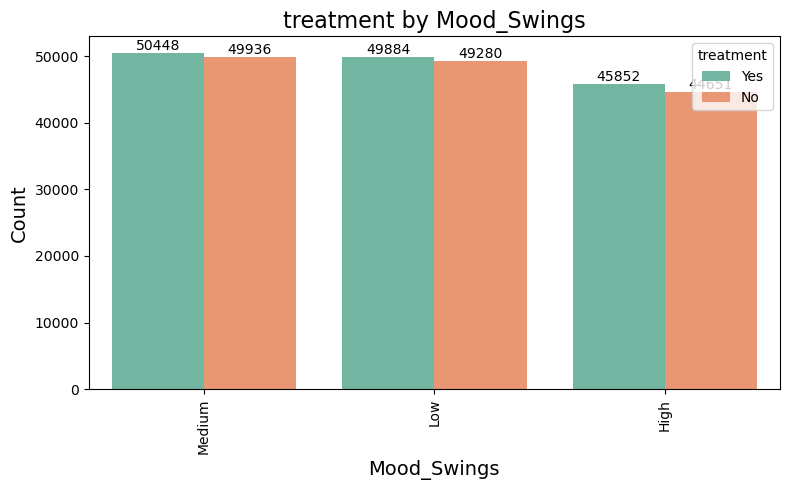

treatment by Coping_Struggles:
treatment               No       Yes
Coping_Struggles                    
No                0.500846  0.499154
Yes               0.490600  0.509400


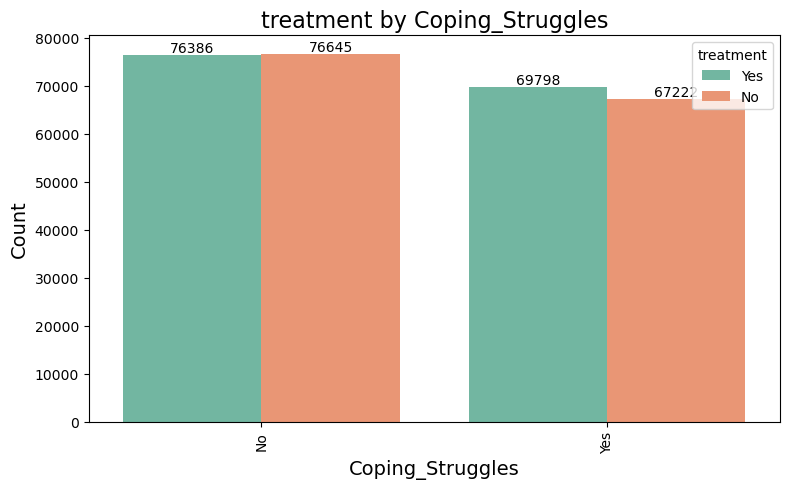

treatment by Work_Interest:
treatment            No       Yes
Work_Interest                    
Maybe          0.497450  0.502550
No             0.497086  0.502914
Yes            0.492954  0.507046


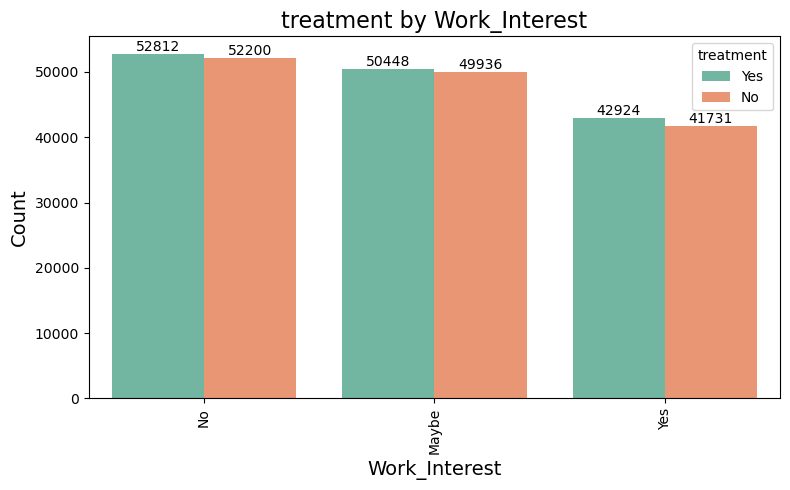

treatment by Social_Weakness:
treatment              No       Yes
Social_Weakness                    
Maybe            0.497490  0.502510
No               0.494947  0.505053
Yes              0.495456  0.504544


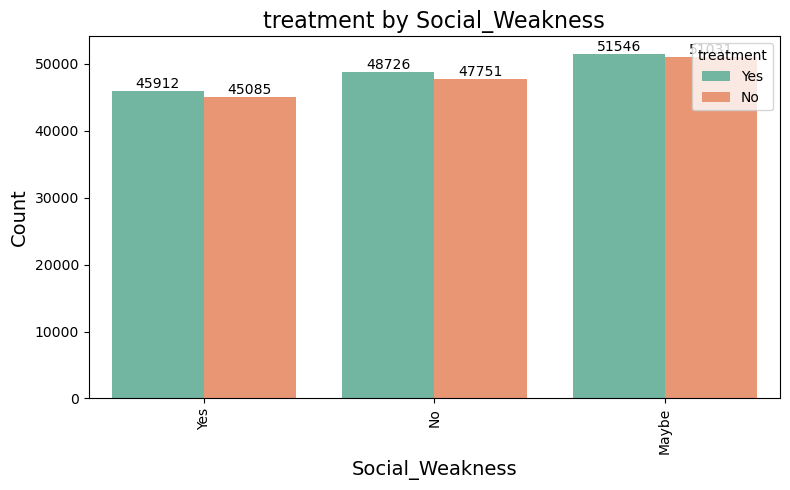

treatment by mental_health_interview:
treatment                      No       Yes
mental_health_interview                    
Maybe                    0.600958  0.399042
No                       0.473933  0.526067
Yes                      0.457140  0.542860


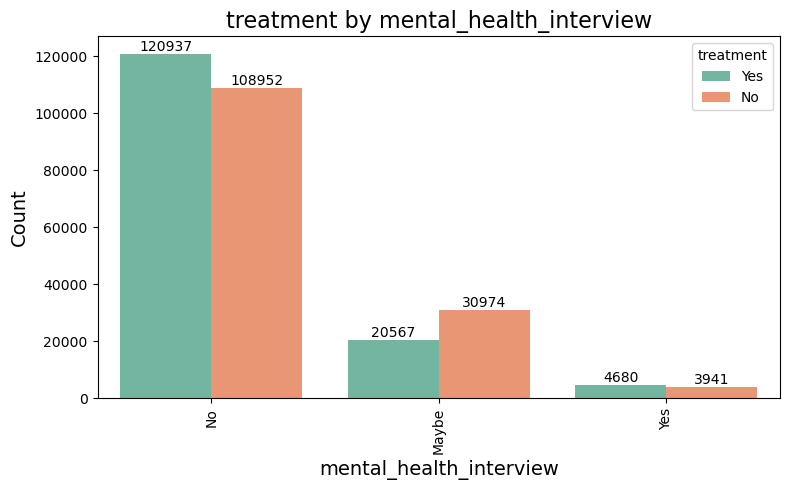

treatment by care_options:
treatment           No       Yes
care_options                    
No            0.591103  0.408897
Not sure      0.606666  0.393334
Yes           0.287357  0.712643


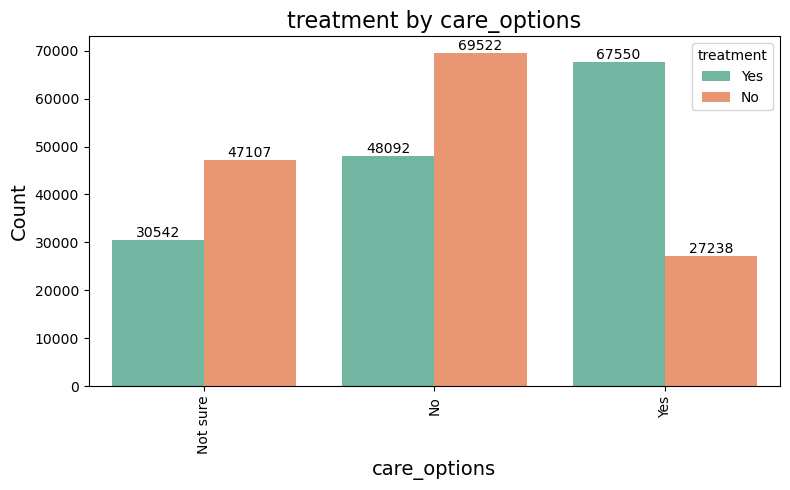

In [13]:
# Get included predictors
columns = df.drop(['treatment'], axis=1).columns

for feature in columns:
    explore_feature_vs_target(df, feature, 'treatment')


### Correlation Analysis
#### Calculate statistical relationships (e.g., Cramér's V for categorical variables) between (**'treatment'**) and other features.

Association Metrics:
- Weak: 0.1 to 0.3
- Moderate: 0.3 to 0.5
- Strong: > 0.5 but not 1

In [14]:
def cramers_v(confusion_matrix):
    """Calculate Cramér's V for correlation between two categorical features.
    
    Returns:
    - chi2_stat (float): Chi-square statistic.
    - p_value (float): p-value of the Chi-square test.
    - cramers_v_value (float): Cramér's V statistic.
    """
    # Compute the Chi-Square statistic and degrees of freedom
    chi2, p_val, _, _ = chi2_contingency(confusion_matrix)
    # Get the number of observations
    n = confusion_matrix.sum().sum()
    # Get the minimum of (number of rows - 1) and (number of columns - 1)
    min_dim = min(confusion_matrix.shape) - 1
    # Calculate Cramér's V
    return chi2, p_val, np.sqrt(chi2 / (n * min_dim))   
    


In [15]:
# Compute correlation between features and 'treatment'

# Get included predictors
columns = df.drop(['treatment'], axis=1).columns

for feature in columns:
    
    cross_tab = pd.crosstab(df[feature], df['treatment'])
    chi2, p, cv = cramers_v(cross_tab)
    if cv > 0.1 and cv != 1:
        print(f"Feature: {feature}")
        print(f"chi^2: {chi2:.4f}")
        print(f"p-value: {p:.4f}")
        print(f"Cramér's V: {cv:.4f}\n")


Feature: Gender
chi^2: 9202.4247
p-value: 0.0000
Cramér's V: 0.1781

Feature: Country
chi^2: 19570.2097
p-value: 0.0000
Cramér's V: 0.2598

Feature: family_history
chi^2: 38584.8689
p-value: 0.0000
Cramér's V: 0.3647

Feature: care_options
chi^2: 24565.7040
p-value: 0.0000
Cramér's V: 0.2910



Results show there are 4 features that have weak to moderate correlation.

The mental health dataset features have non-linear relationships, which means the factors that influences whether a patient needs mental health may interact in more complex ways than a simple direct or inverse relationship. 

Testing with non-linear models (like **Random-Forest**, **XGBoost**, or **SVM** with non-linear kernels) can help to uncover patterns that may be missed by linear models.

## 5. Feature Engineering

In [16]:
# Convert binary features to numeric 1 or 0:
convert_dict = {
    'Yes': 1,
    'No': 0
}

# self-employed, Coping_Struggles, family_history, treatment
for col in df:
    if len(df[col].unique()) == 2 and col != 'Gender':
        df[col] = df[col].replace(convert_dict)
        print(f'feature: {col}, values: {df[col].unique()}')


feature: self_employed, values: [0 1]
feature: family_history, values: [0 1]


/var/folders/4p/9y8h6r_j2vv49_80h13f2lhw0000gn/T/ipykernel_47153/820502090.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(convert_dict)


feature: treatment, values: [1 0]
feature: Coping_Struggles, values: [0 1]


In [17]:
# Hot-encode non-binary features
categorical_cols = df.select_dtypes(include='object', exclude='datetime').columns
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
#for col in categorical_cols:
#    unique_vals = df[col].unique()
#    print(f'feature: {col}, value_count: {len(unique_vals)}, values: {unique_vals}')

In [18]:
df_encoded.head()

,self_employed,family_history,treatment,Coping_Struggles,Gender_Male,Country_Belgium,Country_Bosnia and Herzegovina,Country_Brazil,Country_Canada,Country_Colombia,...,Mood_Swings_Low,Mood_Swings_Medium,Work_Interest_No,Work_Interest_Yes,Social_Weakness_No,Social_Weakness_Yes,mental_health_interview_No,mental_health_interview_Yes,care_options_Not sure,care_options_Yes
0,0,0,1,0,False,False,False,False,False,False,...,False,True,True,False,False,True,True,False,True,False
1,0,1,1,0,False,False,False,False,False,False,...,False,True,True,False,False,True,True,False,False,False
2,0,1,1,0,False,False,False,False,False,False,...,False,True,True,False,False,True,True,False,False,True
3,0,1,1,0,False,False,False,False,False,False,...,False,True,True,False,False,True,False,False,False,True
4,0,1,1,0,False,False,False,False,False,False,...,False,True,True,False,False,True,True,False,False,True


## 6. Baseline Model and Testing

Start with Logistic Regression to get a sense of the data and set a baseline.
Create a Model and train against all features of the dataset.

In [19]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

X = df_encoded.drop('treatment', axis=1)
y = df_encoded['treatment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (217538, 62)
X_test shape: (72513, 62)
y_train shape: (217538,)
y_test shape: (72513,)


In [20]:
# Create and fit the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

### Train-set scores

In [21]:
# Predict probabilities and classes for train set
y_train_probs = model.predict_proba(X_train)[:, 1]
y_train_pred = model.predict(X_train)

In [22]:
print("Train Set Scores:\n")

# Calculate AUC
auc = roc_auc_score(y_train, y_train_probs)
# Calculate F1 Score
f1 = f1_score(y_train, y_train_pred)
print(f'AUC: {auc:.2f}, F1-Score: {f1:.2f}')

# Print Confusion Matrix
cm = confusion_matrix(y_train, y_train_pred)
print("\nConfusion Matrix (Treatment Required):")
print(f' No: {cm[0]}')
print(f'Yes: {cm[1]}')

# Print Classification Report
report = classification_report(y_train, y_train_pred)
print("\nClassification Report:")
print(report)

Train Set Scores:

AUC: 0.79, F1-Score: 0.72

Confusion Matrix (Treatment Required):
 No: [75391 32394]
Yes: [29269 80484]

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.70      0.71    107785
           1       0.71      0.73      0.72    109753

    accuracy                           0.72    217538
   macro avg       0.72      0.72      0.72    217538
weighted avg       0.72      0.72      0.72    217538



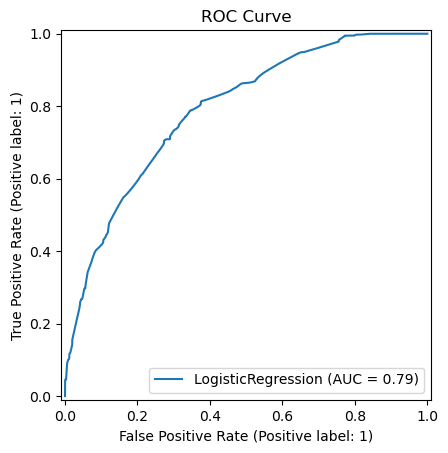

In [23]:
# Plot ROC Curve
RocCurveDisplay.from_estimator(model, X_train, y_train)
plt.title('ROC Curve')
plt.show()

### Test-set Scores

In [24]:
# Predict probabilities and classes for test set
y_probs = model.predict_proba(X_test)[:, 1]  # Probability of the positive class
y_pred = model.predict(X_test)

In [25]:
print("Test Set Scores:\n")

# Calculate AUC
auc = roc_auc_score(y_test, y_probs)
# Calculate F1 Score
f1 = f1_score(y_test, y_pred)
print(f'AUC: {auc:.2f}, F1-Score: {f1:.2f}')

# Print Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix (Treatment Required):")
print(f' No: {cm[0]}')
print(f'Yes: {cm[1]}')

# Print Classification Report
report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(report)

Test Set Scores:

AUC: 0.79, F1-Score: 0.72

Confusion Matrix (Treatment Required):
 No: [25273 10809]
Yes: [ 9838 26593]

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.70      0.71     36082
           1       0.71      0.73      0.72     36431

    accuracy                           0.72     72513
   macro avg       0.72      0.72      0.72     72513
weighted avg       0.72      0.72      0.72     72513



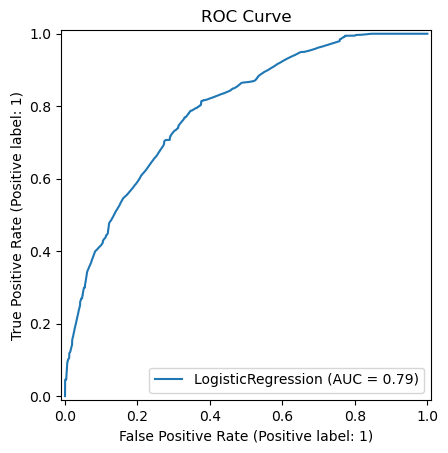

In [26]:
# Plot ROC Curve
RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.title('ROC Curve')
plt.show()

## 7. Summary

**AUC (Area Under Curve)** - An AUC of **0.79** indicates that the model can discern separation between 'Yes' and 'No'. Indicating the probability of predicting that a patient requires mental health support.

**F1 Score** - An F1 score 0f **0.72** indicates a strong balance between precision and recall. This means the model is reasonably good at identifying true-positives with minimal false-positives.

**Confusion Matrix**:
- True Negatives (TN) - **25,395**
- False Positives (FP) - **10,801**
- False Negatives (FN) - **9,819**
- True Positives (TP) - **27,076**
The model makes a number of false-positive, and false-negative predictions. Indicating the the model is too optimistic on predicting a 'Yes', and too many misses in correctly identifying 'Yes' cases.

**ROC Curve** - The curve is above the diagonal which shows a good balance of true-positives to false-positives.


**Recommendation**:
We chose Logistic Regression as our baseline model, even though the Mental Health Dataset, with its entirely categorical features, might be a better fit for non-linear models like Decision Trees, XGBoost, and Random Forest. It’s worth fine-tuning the baseline for added insights, but moving forward, we should explore non-linear classifiers to see how they perform.